In [1]:
from astropy.table import Table, join,unique,vstack
import numpy as np
import pandas as pd
import fitsio
from matplotlib import pyplot as plt
import sys, os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 4
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

from scipy.signal import medfilt
from scipy import stats
from scipy.stats import moment
from astropy.table import Table, join

In [2]:
path = "/media/DOCUMENTOS/Backups/Data"

**In folder:**
Here we have two kind of files: 

- coadd-*: (60 files) are the exposures and information of spectrum in all bands.
- zbest-*: (60 files) have information about the classification an redshift for targets.

**zbest files have two hdu:**

1  ZBEST         1 BinTableHDU  --> lenght: (500, 13) 

colnames= 'TARGETID', 'CHI2', 'COEFF', 'Z', 'ZERR', 'ZWARN', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2'

2  FIBERMAP      1 BinTableHDU  --> lenght: (500) 

**coadd files have two hdu:**

1  FIBERMAP          1 BinTableHDU   --> Same as zbest file.

2  BRZ_WAVELENGTH    1 ImageHDU  --> Wavelenght vector lenght: (7781,), units: 'Angstrom'

3  BRZ_FLUX          1 ImageHDU  --> Spectrum Flux lenght: (7781, 500), units: '10**-17 erg/(s cm2 Angstrom)'

4  BRZ_IVAR          1 ImageHDU  --> Error spectrum flux lenght: (7781, 500), units: '10**+34 (s2 cm4 Angstrom2) / erg2'

5  BRZ_MASK          1 ImageHDU

6  BRZ_RESOLUTION    1 ImageHDU

7  SCORES

In [3]:
date="expo_SV0_march_14_2/"
path_coadds= path+ "/desi_data/"+date
included_extensions = ['hdf5','h5','fits']
file_names_zbest = [fn for fn in os.listdir(path_coadds)
              if any(fn.endswith(ext) for ext in included_extensions[2]) and 'zbest' in fn]
file_names_coadd = [fn for fn in os.listdir(path_coadds)
              if any(fn.endswith(ext) for ext in included_extensions[2]) and 'coadd' in fn]

file_names_coadd = np.sort(file_names_coadd)
file_names_zbest = np.sort(file_names_zbest)
print(file_names_coadd[:4])
print(file_names_zbest[:4])

['coadd-0-65008-20200314.fits' 'coadd-0-66000-20200314.fits'
 'coadd-0-66014-20200314.fits' 'coadd-0-66019-20200314.fits']
['zbest-0-65008-20200314.fits' 'zbest-0-66000-20200314.fits'
 'zbest-0-66014-20200314.fits' 'zbest-0-66019-20200314.fits']


In [4]:
print(fitsio.read(path_coadds+str(file_names_zbest[0]), ext=1)['TARGETID'][:10])
print(fitsio.read(path_coadds+str(file_names_coadd[0]), ext=1)['TARGETID'][:10])

[35186148770843363 35186148770843392 35186148770843761 35186148770844616
 35186148775036873 35186148775037106 35186148775037985 35186148775038185
 35186148775038800 35186148775038953]
[35186148770843363 35186148770843392 35186148770843761 35186148770844616
 35186148775036873 35186148775037106 35186148775037985 35186148775038185
 35186148775038800 35186148775038953]


In [5]:
columns_Z = []
data = np.array(fitsio.read(path_coadds+str(file_names_zbest[0]), ext=1).dtype.names)
columns_Z.append(data)
columns_Z = np.concatenate(columns_Z).flatten()
columns_Z = columns_Z[columns_Z!="COEFF"]
print(columns_Z)

['TARGETID' 'CHI2' 'Z' 'ZERR' 'ZWARN' 'NPIXELS' 'SPECTYPE' 'SUBTYPE'
 'NCOEFF' 'DELTACHI2' 'NUMEXP' 'NUMTILE']


In [6]:
df = pd.DataFrame()
for c in columns_Z:
    data = []
    for f in file_names_zbest:
        if c == "SPECTYPE" or c == "SUBTYPE":
            data.append(fitsio.read(path_coadds+str(f), ext=1)[c].astype(str))
        else:
            data.append(fitsio.read(path_coadds+str(f), ext=1)[c])
    data = np.concatenate(data).flatten()
    df[c] = data
del data
del columns_Z

In [7]:
TILE = []
NIGHT = []
PETAL = []

for f in file_names_zbest:
    dt = fitsio.read(path_coadds+str(f), ext=1)
    for i in dt:
        TILE.append(f.split("-")[2]) #Tile
        NIGHT.append(f.split("-")[3][:-4]) #Night
        PETAL.append(f.split("-")[1]) #Petal

df['TILE'] = TILE
df['NIGHT'] = NIGHT
df['PETAL'] = PETAL

del TILE
del NIGHT
del PETAL

In [8]:
df.head()

TARGETID          CHI2         Z          ZERR  ZWARN  NPIXELS  \
0  35186148770843363  1.270709e+04 -0.000116  4.196049e-06      0     7928   
1  35186148770843392  9.000000e+99 -0.001996  4.131160e-48   1570        0   
2  35186148770843761  1.039053e+04  0.000073  6.841897e-06      0     7929   
3  35186148770844616  9.012406e+03  0.000272  2.616569e-05      0     7930   
4  35186148775036873  9.322706e+03 -0.000187  1.679440e-05      0     7924   

  SPECTYPE SUBTYPE  NCOEFF     DELTACHI2  NUMEXP  NUMTILE   TILE      NIGHT  \
0     STAR       M       5  1.009078e+04       0        1  65008  20200314.   
1     STAR      CV       3  1.942669e+84       0        1  65008  20200314.   
2     STAR       M       5  5.975452e+03       0        1  65008  20200314.   
3     STAR       K       5  1.670016e+02       0        1  65008  20200314.   
4     STAR       K       5  4.294787e+01       0        1  65008  20200314.   

  PETAL  
0     0  
1     0  
2     0  
3     0  
4     0

In [9]:
df[df['TARGETID']==35191270368348424]

Empty DataFrame
Columns: [TARGETID, CHI2, Z, ZERR, ZWARN, NPIXELS, SPECTYPE, SUBTYPE, NCOEFF, DELTACHI2, NUMEXP, NUMTILE, TILE, NIGHT, PETAL]
Index: []

In [10]:
np.unique(df['TILE'])

array(['65008', '66000', '66014', '66019', '67230', '68000'], dtype=object)

In [11]:
df.head()

TARGETID          CHI2         Z          ZERR  ZWARN  NPIXELS  \
0  35186148770843363  1.270709e+04 -0.000116  4.196049e-06      0     7928   
1  35186148770843392  9.000000e+99 -0.001996  4.131160e-48   1570        0   
2  35186148770843761  1.039053e+04  0.000073  6.841897e-06      0     7929   
3  35186148770844616  9.012406e+03  0.000272  2.616569e-05      0     7930   
4  35186148775036873  9.322706e+03 -0.000187  1.679440e-05      0     7924   

  SPECTYPE SUBTYPE  NCOEFF     DELTACHI2  NUMEXP  NUMTILE   TILE      NIGHT  \
0     STAR       M       5  1.009078e+04       0        1  65008  20200314.   
1     STAR      CV       3  1.942669e+84       0        1  65008  20200314.   
2     STAR       M       5  5.975452e+03       0        1  65008  20200314.   
3     STAR       K       5  1.670016e+02       0        1  65008  20200314.   
4     STAR       K       5  4.294787e+01       0        1  65008  20200314.   

  PETAL  
0     0  
1     0  
2     0  
3     0  
4     0

In [12]:
print(fitsio.read(path_coadds+str(file_names_zbest[1]), ext=1)['TARGETID'][:10])

[35190924355044323 35190924355044338 35190924355044601 35190924355044681
 35190924355045044 35190924355045404 35190924355045408 35190924355045730
 35190924355045909 35190924355046286]


In [13]:
targetidc = np.zeros(len(df),dtype=int)
flux = np.zeros(len(df),dtype=object)
wavelength = np.zeros(len(df),dtype=object)
errflux = np.zeros(len(df),dtype=object)

k=0
for f in file_names_coadd:
    tid = fitsio.read(path_coadds+str(f), ext=1)['TARGETID']
    wl = fitsio.read(path_coadds+str(f), ext=2)
    flx = fitsio.read(path_coadds+str(f), ext=3)
    errflx = fitsio.read(path_coadds+str(f), ext=4)
    for i,t in enumerate(tid):
        if sum(flx[i]) != 0:
            targetidc[k] = int(t)
            wavelength[k] = wl
            flux[k] = flx[i]
            errflux[k] = errflx[i]
            k = k+1
    del tid
    del wl
    del flx
    del errflx

In [14]:
df2 = pd.DataFrame()
df2['TARGETID'] = np.array(targetidc).astype(int)
df2['WAVELENGTH'] = np.array(wavelength)
df2['FLUX'] = np.array(flux)
df2['ERRFLUX'] = np.array(errflux)

In [15]:
df2[df2['TARGETID']==35191270368348424]

Empty DataFrame
Columns: [TARGETID, WAVELENGTH, FLUX, ERRFLUX]
Index: []

In [16]:
dff = pd.merge(df2, df, on=['TARGETID'])

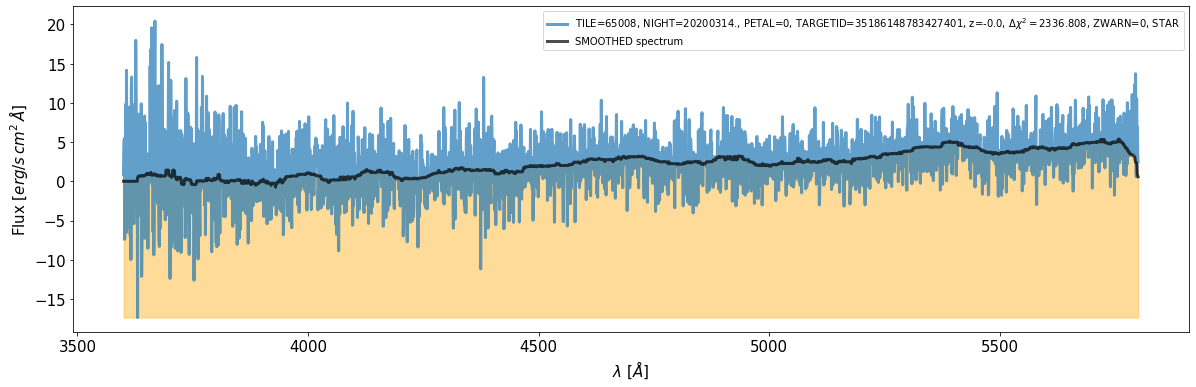

In [17]:
plt.figure(figsize=(20,6))
ii = 20
plt.plot(np.array(dff['WAVELENGTH'][ii]),dff['FLUX'][ii],
         label="TILE="+str(dff['TILE'][ii])+", "+"NIGHT="+str(dff['NIGHT'][ii])
         +", "+"PETAL="+str(dff['PETAL'][ii])+", "+"TARGETID="+str(int(dff['TARGETID'][ii]))
         +", "+"z="+str(round(dff['Z'][ii],3))+", "+"$\Delta\chi^2=$"+str(round(dff['DELTACHI2'][ii],3))
         +", "+"ZWARN="+str(dff['ZWARN'][ii])+", "+str(dff['SPECTYPE'][ii]),alpha=0.7)
plt.plot(dff['WAVELENGTH'][ii],medfilt(dff['FLUX'][ii], 101),
         label="SMOOTHED spectrum",alpha=0.7,color='k')
plt.fill_between(dff['WAVELENGTH'][ii],medfilt(dff['FLUX'][ii], 101),np.min(dff['FLUX'][ii]),alpha=0.4,color='orange')
plt.legend()
plt.xlabel("$\lambda$ $[\AA]$")
plt.ylabel("Flux $[erg/s\,cm^2\,\AA]$")
plt.show()

In [18]:
dff.head()

TARGETID                                         WAVELENGTH  \
0  35186148770843363  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
1  35186148770843761  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
2  35186148770844616  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
3  35186148775036873  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
4  35186148775037106  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                FLUX  \
0  [16.629738, -7.133062, 4.2576985, 25.119408, 9...   
1  [0.032739643, 10.340323, 0.28587627, 16.81467,...   
2  [9.3599, -0.30654413, 20.865473, 3.4739144, 21...   
3  [0.5740119, 2.6363888, -8.660715, -6.4718666, ...   
4  [-0.729177, 6.761434, 12.152129, 18.775274, 31...   

                                             ERRFLUX          CHI2         Z  \
0  [0.017274935, 0.010060674, 0.010030603, 0.0073...  12707.085760 -0.000116   
1  [0.02114713, 0.010559111, 0.010497417, 0.00900...  10390.526888  0.000073   
2  [0.018445576, 0.009608054, 0.009228553, 0.0082...   9012.405702  0.000272   
3  [0.019074239, 0.008593588, 0.011730482, 0.0095...   9322.706255 -0.000187   
4  [0.01886503, 0.0092472015, 0.010697438, 0.0077...  10271.535701 -0.000076   

       ZERR  ZWARN  NPIXELS SPECTYPE SUBTYPE  NCOEFF     DELTACHI2  NUMEXP  \
0  0.000004      0     7928     STAR       M       5  10090.780903       0   
1  0.000007      0     7929     STAR       M       5   5975.451571       0   
2  0.000026      0     7930     STAR       K       5    167.001616       0   
3  0.000017      0     7924     STAR       K       5     42.947868       0   
4  0.000008      0     7926     STAR       K       5   1487.379914       0   

   NUMTILE   TILE      NIGHT PETAL  
0        1  65008  20200314.     0  
1        1  65008  20200314.     0  
2        1  65008  20200314.     0  
3        1  65008  20200314.     0  
4        1  65008  20200314.     0

In [19]:
dff.keys()

Index(['TARGETID', 'WAVELENGTH', 'FLUX', 'ERRFLUX', 'CHI2', 'Z', 'ZERR',
       'ZWARN', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2',
       'NUMEXP', 'NUMTILE', 'TILE', 'NIGHT', 'PETAL'],
      dtype='object')

In [20]:
dff.to_pickle(path_coadds+str(path_coadds.split("/")[-2])+'.csv')
print(path_coadds+str(path_coadds.split("/")[-2])+'.csv')

/media/DOCUMENTOS/Backups/Data/desi_data/expo_SV0_march_14_2/expo_SV0_march_14_2.csv


In [21]:
ii = int(dff['TARGETID'][1])
print(ii)
df[df['TARGETID']==ii]

35186148770843761


TARGETID          CHI2         Z      ZERR  ZWARN  NPIXELS  \
2  35186148770843761  10390.526888  0.000073  0.000007      0     7929   

  SPECTYPE SUBTYPE  NCOEFF    DELTACHI2  NUMEXP  NUMTILE   TILE      NIGHT  \
2     STAR       M       5  5975.451571       0        1  65008  20200314.   

  PETAL  
2     0

In [22]:
df2[df2['TARGETID']==ii]

TARGETID                                         WAVELENGTH  \
1  35186148770843761  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                FLUX  \
1  [0.032739643, 10.340323, 0.28587627, 16.81467,...   

                                             ERRFLUX  
1  [0.02114713, 0.010559111, 0.010497417, 0.00900...

In [23]:
dff[dff['TARGETID']==ii]

TARGETID                                         WAVELENGTH  \
1  35186148770843761  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                FLUX  \
1  [0.032739643, 10.340323, 0.28587627, 16.81467,...   

                                             ERRFLUX          CHI2         Z  \
1  [0.02114713, 0.010559111, 0.010497417, 0.00900...  10390.526888  0.000073   

       ZERR  ZWARN  NPIXELS SPECTYPE SUBTYPE  NCOEFF    DELTACHI2  NUMEXP  \
1  0.000007      0     7929     STAR       M       5  5975.451571       0   

   NUMTILE   TILE      NIGHT PETAL  
1        1  65008  20200314.     0

In [24]:
dff

TARGETID                                         WAVELENGTH  \
0       35186148770843363  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
1       35186148770843761  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
2       35186148770844616  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
3       35186148775036873  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
4       35186148775037106  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
...                   ...                                                ...   
22100  611652019035308252  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22101  611652019035308990  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22102  611652022675964123  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22103  611652022675964343  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22104  611652022675964670  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                    FLUX  \
0      [16.629738, -7.133062, 4.2576985, 25.119408, 9...   
1      [0.032739643, 10.340323, 0.28587627, 16.81467,...   
2      [9.3599, -0.30654413, 20.865473, 3.4739144, 21...   
3      [0.5740119, 2.6363888, -8.660715, -6.4718666, ...   
4      [-0.729177, 6.761434, 12.152129, 18.775274, 31...   
...                                                  ...   
22100  [0.5972299, 17.676579, 10.872576, 0.93220675, ...   
22101  [4.4486704, -6.756239, -6.7208223, -7.9544024,...   
22102  [9.209778, 3.8351939, -3.8647337, 3.0884986, -...   
22103  [2.428212, -0.7727672, -0.617631, 2.0263023, -...   
22104  [8.260263, -6.7957487, 3.433288, -4.431857, -2...   

                                                 ERRFLUX          CHI2  \
0      [0.017274935, 0.010060674, 0.010030603, 0.0073...  12707.085760   
1      [0.02114713, 0.010559111, 0.010497417, 0.00900...  10390.526888   
2      [0.018445576, 0.009608054, 0.009228553, 0.0082...   9012.405702   
3      [0.019074239, 0.008593588, 0.011730482, 0.0095...   9322.706255   
4      [0.01886503, 0.0092472015, 0.010697438, 0.0077...  10271.535701   
...                                                  ...           ...   
22100  [0.00909646, 0.009056626, 0.012580914, 0.01638...   9479.129530   
22101  [0.012542188, 0.012960598, 0.016695278, 0.0209...   9059.794404   
22102  [0.012941558, 0.014030245, 0.017447231, 0.0226...   9233.822045   
22103  [0.009500552, 0.0090708155, 0.011421528, 0.015...   9129.063329   
22104  [0.013174635, 0.013536587, 0.017266715, 0.0237...   9092.427711   

              Z      ZERR  ZWARN  NPIXELS SPECTYPE SUBTYPE  NCOEFF  \
0     -0.000116  0.000004      0     7928     STAR       M       5   
1      0.000073  0.000007      0     7929     STAR       M       5   
2      0.000272  0.000026      0     7930     STAR       K       5   
3     -0.000187  0.000017      0     7924     STAR       K       5   
4     -0.000076  0.000008      0     7926     STAR       K       5   
...         ...       ...    ...      ...      ...     ...     ...   
22100  0.689862  0.000087      4     7926   GALAXY              10   
22101  0.289601  0.000105      4     7904   GALAXY              10   
22102  0.802210  0.000133      4     7902   GALAXY              10   
22103  0.802328  0.000058      4     7925   GALAXY              10   
22104  0.276225  0.000059      4     7883   GALAXY              10   

          DELTACHI2  NUMEXP  NUMTILE   TILE      NIGHT PETAL  
0      10090.780903       0        1  65008  20200314.     0  
1       5975.451571       0        1  65008  20200314.     0  
2        167.001616       0        1  65008  20200314.     0  
3         42.947868       0        1  65008  20200314.     0  
4       1487.379914       0        1  65008  20200314.     0  
...             ...     ...      ...    ...        ...   ...  
22100      2.981981       0        1  68000  20200314.     9  
22101      0.768590       0        1  68000  20200314.     9  
22102      4.439055       0        1  

In [25]:
df2 

TARGETID                                         WAVELENGTH  \
0      35186148770843363  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
1      35186148770843761  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
2      35186148770844616  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
3      35186148775036873  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
4      35186148775037106  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
...                  ...                                                ...   
26995                  0                                                  0   
26996                  0                                                  0   
26997                  0                                                  0   
26998                  0                                                  0   
26999                  0                                                  0   

                                                    FLUX  \
0      [16.629738, -7.133062, 4.2576985, 25.119408, 9...   
1      [0.032739643, 10.340323, 0.28587627, 16.81467,...   
2      [9.3599, -0.30654413, 20.865473, 3.4739144, 21...   
3      [0.5740119, 2.6363888, -8.660715, -6.4718666, ...   
4      [-0.729177, 6.761434, 12.152129, 18.775274, 31...   
...                                                  ...   
26995                                                  0   
26996                                                  0   
26997                                                  0   
26998                                                  0   
26999                                                  0   

                                                 ERRFLUX  
0      [0.017274935, 0.010060674, 0.010030603, 0.0073...  
1      [0.02114713, 0.010559111, 0.010497417, 0.00900...  
2      [0.018445576, 0.009608054, 0.009228553, 0.0082...  
3      [0.019074239, 0.008593588, 0.011730482, 0.0095...  
4      [0.01886503, 0.0092472015, 0.010697438, 0.0077...  
...                                                  ...  
26995                                                  0  
26996                                                  0  
26997                                                  0  
26998                                                  0  
26999                                                  0  

[27000 rows x 4 columns]

In [26]:
df

TARGETID          CHI2         Z          ZERR  ZWARN  \
0       35186148770843363  1.270709e+04 -0.000116  4.196049e-06      0   
1       35186148770843392  9.000000e+99 -0.001996  4.131160e-48   1570   
2       35186148770843761  1.039053e+04  0.000073  6.841897e-06      0   
3       35186148770844616  9.012406e+03  0.000272  2.616569e-05      0   
4       35186148775036873  9.322706e+03 -0.000187  1.679440e-05      0   
...                   ...           ...       ...           ...    ...   
26995  611652022675964123  9.233822e+03  0.802210  1.325563e-04      4   
26996  611652022675964343  9.129063e+03  0.802328  5.761448e-05      4   
26997  611652022675964452  9.000000e+99 -0.001996  4.131160e-48   1570   
26998  611652022675964560  9.000000e+99 -0.001996  4.131160e-48   1570   
26999  611652022675964670  9.092428e+03  0.276225  5.891298e-05      4   

       NPIXELS SPECTYPE SUBTYPE  NCOEFF     DELTACHI2  NUMEXP  NUMTILE   TILE  \
0         7928     STAR       M       5  1.009078e+04       0        1  65008   
1            0     STAR      CV       3  1.942669e+84       0        1  65008   
2         7929     STAR       M       5  5.975452e+03       0        1  65008   
3         7930     STAR       K       5  1.670016e+02       0        1  65008   
4         7924     STAR       K       5  4.294787e+01       0        1  65008   
...        ...      ...     ...     ...           ...     ...      ...    ...   
26995     7902   GALAXY              10  4.439055e+00       0        1  68000   
26996     7925   GALAXY              10  8.497784e+00       0        1  68000   
26997        0     STAR      CV       3  1.942669e+84       0        1  68000   
26998        0     STAR      CV       3  1.942669e+84       0        1  68000   
26999     7883   GALAXY              10  5.615963e+00       0        1  68000   

           NIGHT PETAL  
0      20200314.     0  
1      20200314.     0  
2      20200314.     0  
3      20200314.     0  
4      20200314.     0  
...          ...   ...  
26995  20200314.     9  
26996  20200314.     9  
26997  20200314.     9  
26998  20200314.     9  
26999  20200314.     9  

[27000 rows x 15 columns]

In [27]:
df.reset_index(drop=True)

TARGETID          CHI2         Z          ZERR  ZWARN  \
0       35186148770843363  1.270709e+04 -0.000116  4.196049e-06      0   
1       35186148770843392  9.000000e+99 -0.001996  4.131160e-48   1570   
2       35186148770843761  1.039053e+04  0.000073  6.841897e-06      0   
3       35186148770844616  9.012406e+03  0.000272  2.616569e-05      0   
4       35186148775036873  9.322706e+03 -0.000187  1.679440e-05      0   
...                   ...           ...       ...           ...    ...   
26995  611652022675964123  9.233822e+03  0.802210  1.325563e-04      4   
26996  611652022675964343  9.129063e+03  0.802328  5.761448e-05      4   
26997  611652022675964452  9.000000e+99 -0.001996  4.131160e-48   1570   
26998  611652022675964560  9.000000e+99 -0.001996  4.131160e-48   1570   
26999  611652022675964670  9.092428e+03  0.276225  5.891298e-05      4   

       NPIXELS SPECTYPE SUBTYPE  NCOEFF     DELTACHI2  NUMEXP  NUMTILE   TILE  \
0         7928     STAR       M       5  1.009078e+04       0        1  65008   
1            0     STAR      CV       3  1.942669e+84       0        1  65008   
2         7929     STAR       M       5  5.975452e+03       0        1  65008   
3         7930     STAR       K       5  1.670016e+02       0        1  65008   
4         7924     STAR       K       5  4.294787e+01       0        1  65008   
...        ...      ...     ...     ...           ...     ...      ...    ...   
26995     7902   GALAXY              10  4.439055e+00       0        1  68000   
26996     7925   GALAXY              10  8.497784e+00       0        1  68000   
26997        0     STAR      CV       3  1.942669e+84       0        1  68000   
26998        0     STAR      CV       3  1.942669e+84       0        1  68000   
26999     7883   GALAXY              10  5.615963e+00       0        1  68000   

           NIGHT PETAL  
0      20200314.     0  
1      20200314.     0  
2      20200314.     0  
3      20200314.     0  
4      20200314.     0  
...          ...   ...  
26995  20200314.     9  
26996  20200314.     9  
26997  20200314.     9  
26998  20200314.     9  
26999  20200314.     9  

[27000 rows x 15 columns]

In [28]:
dff

TARGETID                                         WAVELENGTH  \
0       35186148770843363  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
1       35186148770843761  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
2       35186148770844616  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
3       35186148775036873  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
4       35186148775037106  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
...                   ...                                                ...   
22100  611652019035308252  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22101  611652019035308990  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22102  611652022675964123  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22103  611652022675964343  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   
22104  611652022675964670  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                    FLUX  \
0      [16.629738, -7.133062, 4.2576985, 25.119408, 9...   
1      [0.032739643, 10.340323, 0.28587627, 16.81467,...   
2      [9.3599, -0.30654413, 20.865473, 3.4739144, 21...   
3      [0.5740119, 2.6363888, -8.660715, -6.4718666, ...   
4      [-0.729177, 6.761434, 12.152129, 18.775274, 31...   
...                                                  ...   
22100  [0.5972299, 17.676579, 10.872576, 0.93220675, ...   
22101  [4.4486704, -6.756239, -6.7208223, -7.9544024,...   
22102  [9.209778, 3.8351939, -3.8647337, 3.0884986, -...   
22103  [2.428212, -0.7727672, -0.617631, 2.0263023, -...   
22104  [8.260263, -6.7957487, 3.433288, -4.431857, -2...   

                                                 ERRFLUX          CHI2  \
0      [0.017274935, 0.010060674, 0.010030603, 0.0073...  12707.085760   
1      [0.02114713, 0.010559111, 0.010497417, 0.00900...  10390.526888   
2      [0.018445576, 0.009608054, 0.009228553, 0.0082...   9012.405702   
3      [0.019074239, 0.008593588, 0.011730482, 0.0095...   9322.706255   
4      [0.01886503, 0.0092472015, 0.010697438, 0.0077...  10271.535701   
...                                                  ...           ...   
22100  [0.00909646, 0.009056626, 0.012580914, 0.01638...   9479.129530   
22101  [0.012542188, 0.012960598, 0.016695278, 0.0209...   9059.794404   
22102  [0.012941558, 0.014030245, 0.017447231, 0.0226...   9233.822045   
22103  [0.009500552, 0.0090708155, 0.011421528, 0.015...   9129.063329   
22104  [0.013174635, 0.013536587, 0.017266715, 0.0237...   9092.427711   

              Z      ZERR  ZWARN  NPIXELS SPECTYPE SUBTYPE  NCOEFF  \
0     -0.000116  0.000004      0     7928     STAR       M       5   
1      0.000073  0.000007      0     7929     STAR       M       5   
2      0.000272  0.000026      0     7930     STAR       K       5   
3     -0.000187  0.000017      0     7924     STAR       K       5   
4     -0.000076  0.000008      0     7926     STAR       K       5   
...         ...       ...    ...      ...      ...     ...     ...   
22100  0.689862  0.000087      4     7926   GALAXY              10   
22101  0.289601  0.000105      4     7904   GALAXY              10   
22102  0.802210  0.000133      4     7902   GALAXY              10   
22103  0.802328  0.000058      4     7925   GALAXY              10   
22104  0.276225  0.000059      4     7883   GALAXY              10   

          DELTACHI2  NUMEXP  NUMTILE   TILE      NIGHT PETAL  
0      10090.780903       0        1  65008  20200314.     0  
1       5975.451571       0        1  65008  20200314.     0  
2        167.001616       0        1  65008  20200314.     0  
3         42.947868       0        1  65008  20200314.     0  
4       1487.379914       0        1  65008  20200314.     0  
...             ...     ...      ...    ...        ...   ...  
22100      2.981981       0        1  68000  20200314.     9  
22101      0.768590       0        1  68000  20200314.     9  
22102      4.439055       0        1  

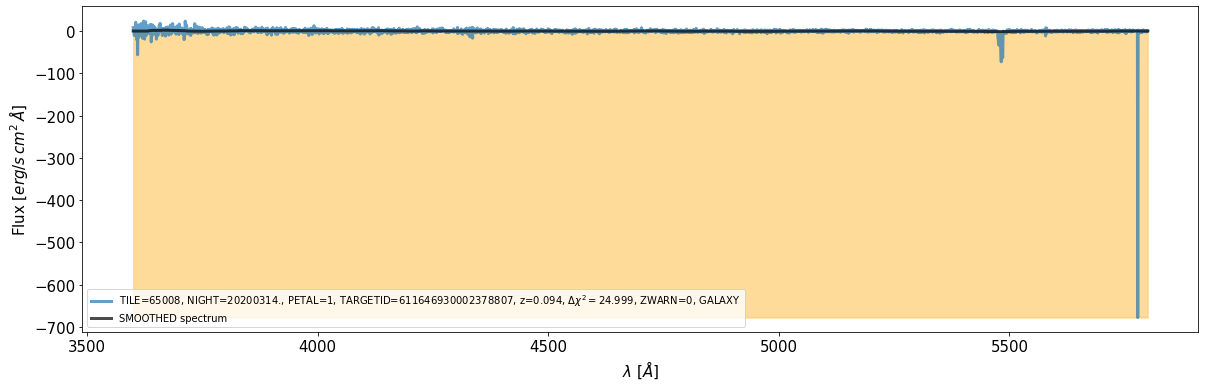

In [33]:
plt.figure(figsize=(20,6))
ii = dff[dff['TARGETID']==611646930002378807].index[0]
plt.plot(np.array(dff['WAVELENGTH'][ii]),dff['FLUX'][ii],
         label="TILE="+str(dff['TILE'][ii])+", "+"NIGHT="+str(dff['NIGHT'][ii])
         +", "+"PETAL="+str(dff['PETAL'][ii])+", "+"TARGETID="+str(int(dff['TARGETID'][ii]))
         +", "+"z="+str(round(dff['Z'][ii],3))+", "+"$\Delta\chi^2=$"+str(round(dff['DELTACHI2'][ii],3))
         +", "+"ZWARN="+str(dff['ZWARN'][ii])+", "+str(dff['SPECTYPE'][ii]),alpha=0.7)
plt.plot(dff['WAVELENGTH'][ii],medfilt(dff['FLUX'][ii], 101),
         label="SMOOTHED spectrum",alpha=0.7,color='k')
plt.fill_between(dff['WAVELENGTH'][ii],medfilt(dff['FLUX'][ii], 101),np.min(dff['FLUX'][ii]),alpha=0.4,color='orange')
plt.legend()
plt.xlabel("$\lambda$ $[\AA]$")
plt.ylabel("Flux $[erg/s\,cm^2\,\AA]$")
plt.show()

In [35]:
dff[dff['TARGETID']==611646930002378807]

TARGETID                                         WAVELENGTH  \
3134  611646930002378807  [3600.0, 3600.8, 3601.6000000000004, 3602.4000...   

                                                   FLUX  \
3134  [8.129542, 1.8897736, 7.0428133, -10.450904, 3...   

                                                ERRFLUX         CHI2        Z  \
3134  [0.0029861103, 0.018009545, 0.013058173, 0.013...  9030.426233  0.09409   

          ZERR  ZWARN  NPIXELS SPECTYPE SUBTYPE  NCOEFF  DELTACHI2  NUMEXP  \
3134  0.000058      0     7882   GALAXY              10  24.998891       0   

      NUMTILE   TILE      NIGHT PETAL  
3134        1  65008  20200314.     1